In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import linear_model

In [2]:
pd.set_option('display.max_columns', 100)
train=pd.read_csv("train.csv", sep="|")
test = pd.read_csv("test.csv", sep="|")
train['totalScanned'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
test['totalScanned'] = test['scannedLineItemsPerSecond'] * test['totalScanTimeInSeconds']
data = pd.concat([test,train],sort=False)
datawoF = data.drop('fraud', axis=1)

In [31]:
train.describe()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,totalScanned
count,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000
mean,3.401809,932.153273,50.864492,5.469931,4.904204,2.525279,0.058138,0.201746,0.745404,0.055349,15.383183
std,1.709404,530.144640,28.940202,3.451169,3.139697,1.695472,0.278512,1.242135,1.327241,0.228720,8.707411
min,1.000000,2.000000,0.010000,0.000000,0.000000,0.000000,0.000548,0.000007,0.000000,0.000000,1.000000
25%,2.000000,474.500000,25.965000,2.000000,2.000000,1.000000,0.008384,0.027787,0.160000,0.000000,8.000000
50%,3.000000,932.000000,51.210000,5.000000,5.000000,3.000000,0.016317,0.054498,0.350000,0.000000,15.000000
75%,5.000000,1397.000000,77.285000,8.000000,8.000000,4.000000,0.032594,0.107313,0.666667,0.000000,23.000000
max,6.000000,1831.000000,99.960000,11.000000,10.000000,5.000000,6.666667,37.870000,11.000000,1.000000,30.000000


/home/jonny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


[1.41096385e+02 2.56616230e+01 8.44562488e+00 3.91094352e+00
 2.45369947e+00 2.22580989e+00 1.57470900e+00 1.02524428e+00
 8.85955184e-01 6.13762499e-01 6.78367767e-15]


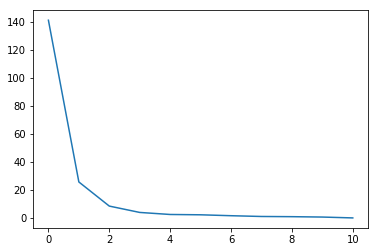

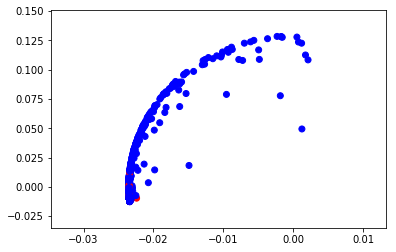

In [20]:
#normalise data per column
t = preprocessing.scale(train,axis=1)
#compute svd as U * S * V.T
u,s,vh = np.linalg.svd(t,full_matrices=False)
print(s)
plt.plot(s) # scree plot. A visual way to see which singular vectors are actually important
truncated = u[:,0:2] # keep only the important ones
plt.show()
#I plottet some singular values against the others. The data is somewhat separated, but not really
plt.scatter(u[:,0],u[:,1],c=['Blue' if s == 0 else 'Red' for s in train['fraud']])
plt.show()


In [15]:
#train some logistic regression on the compressed data
lreg = linear_model.LogisticRegressionCV(cv=5,class_weight='balanced')
lreg.fit(truncated,train['fraud'])
print("ACC for compressed data",lreg.score(truncated,train['fraud']))
#train some logistic regression on the real data
lreg2 = linear_model.LogisticRegressionCV(cv=5,class_weight='balanced',solver='liblinear')
lreg2.fit(train.drop(columns='fraud'),train['fraud'])
print("ACC for uncompressed data",lreg2.score(train.drop(columns='fraud'),train['fraud']))
#and observe that it is kind of harmfull :/

ACC for compressed data 0.3459286854709952
ACC for uncompressed data 0.99308142629058


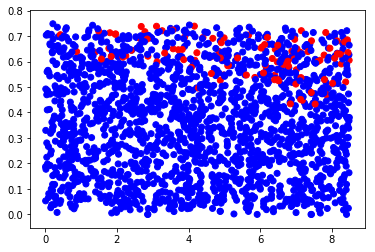

In [11]:
#as our data is non-negative. let's try non-negative matrix factorisation
a = decomposition.NMF(n_components=3).fit_transform(train)
#and observe that it still doesn't help to separate our data
plt.scatter(a[:,0],a[:,2],c=['Blue' if s == 0 else 'Red' for s in train['fraud']])



In [12]:
#train some logistic regression on the compressed data
lreg = linear_model.LogisticRegressionCV(cv=5,class_weight='balanced')
lreg.fit(a,train['fraud'])
print("ACC for compressed data",lreg.score(a,train['fraud']))
#train some logistic regression on the real data
lreg2 = linear_model.LogisticRegressionCV(cv=5,class_weight='balanced',solver='liblinear')
lreg2.fit(train.drop(columns='fraud'),train['fraud'])
print("ACC for uncompressed data",lreg2.score(train.drop(columns='fraud'),train['fraud']))
#and observe that it is still kind of harmfull but works way better

ACC for compressed data 0.7972325705162321
ACC for uncompressed data 0.99308142629058


In [27]:
#outlier detection
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
outliertrainer = train
estimators = {'LOF': LocalOutlierFactor(), 'SVM': OneClassSVM(), 'IsoForest': IsolationForest()}
for e_name, estimator in estimators.items():
    name = 'status_'+e_name
    outliertrainer[name]= estimator.fit_predict(train)!=1
outliertrainer

/home/jonny/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jonny/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/jonny/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/jonny/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,totalScanned,status_LOF,status_SVM,status_IsoForest
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0,29.0,False,False,False
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0,14.0,False,True,False
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0,13.0,False,False,False
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0,29.0,False,False,False
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0,27.0,False,True,False
5,1,770,11.09,11,5,2,0.033766,0.014403,0.423077,1,26.0,False,True,False
6,3,294,55.63,2,7,1,0.037415,0.189218,0.181818,0,11.0,False,True,False
7,2,1545,22.80,0,8,4,0.006472,0.014757,0.000000,0,10.0,False,False,False
8,6,962,65.44,7,0,2,0.028067,0.068025,0.259259,0,27.0,False,False,False
9,2,725,41.08,10,2,4,0.037241,0.056662,0.370370,0,27.0,False,False,False


In [51]:
ensembleOut = outliertrainer.query('status_LOF == True and status_SVM == True and status_IsoForest == True')
isoF= outliertrainer.query('status_IsoForest == True')
frauds = train[train['fraud']==1]
res = pd.merge(frauds,isoF,how='outer', indicator=True)
res= res.query('fraud == 1')
print("using and IsoForest yields a higher percentage of frauds in the data",np.mean(isoF['fraud']))
print("But it misses too many frauds (left_only)\n",res['_merge'].value_counts())


using and IsoForest yields a higher percentage of frauds in the data 0.20212765957446807
But it misses too many frauds (left_only)
 left_only     66
both          38
right_only     0
Name: _merge, dtype: int64


In [52]:
from sklearn import decomposition

def attachNMF(train,n_components=3):
    '''
    attaches a non-negative matrix factorisation to the data. Maybe this helps on predicting.
    
    train: the data to use
    n_components: How many components should be added, will be adjustable in the future.
    
    returns: the data with the 
    '''
    a = decomposition.NMF(n_components=n_components).fit_transform(train)

    train['u0']=a[:,0]
    train['u1']=a[:,1]
    train['u2']=a[:,2]
    return train


In [53]:
from sklearn.ensemble import IsolationForest

def attachOutlierScore(train):
    '''
    attaches the outlier score of an isolation forest to the data.
    IsoForest was the only method which provided more insight to the data
    '''
    f = IsolationForest()
    f.fit(train)
    train['outlierscore']=f.decision_function(train)
    return train